# Quantum Pytorch Modeling

## 0. Setup

In [1]:
import qiskit
from qiskit_algorithms.utils import algorithm_globals
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN

import torch
from torch import cat, no_grad, manual_seed

import pandas as pd

import matplotlib.pyplot as plt

from src.utils import plot_doodle


SEED = 42

BATCH_SIZE = 1
N_SAMPLES = 100

manual_seed(SEED)
algorithm_globals.random_seed = SEED

## 1. Data preprocessing

## 2. Hybrid-modeling

In [2]:
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

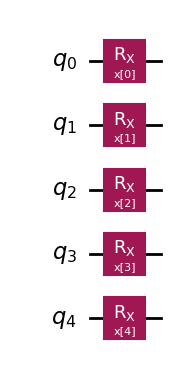

In [3]:
# Ejemplo de Feature Map:
n_qubits = 5
circuit = quantum_feature_map(n_qubits)
circuit.draw('mpl')

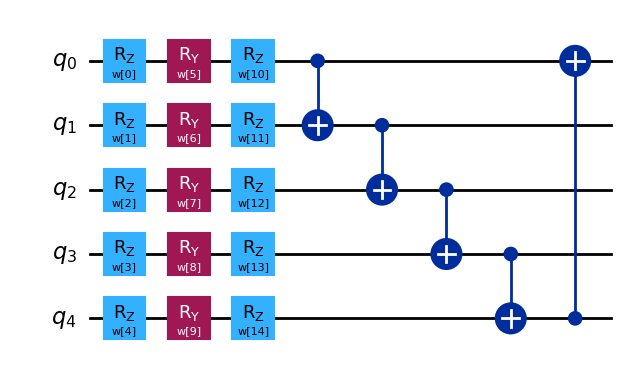

In [4]:
# Ejemplo de Ansatz:
n_qubits = 5
circuit = quantum_ansatz(n_qubits)
circuit.draw('mpl')

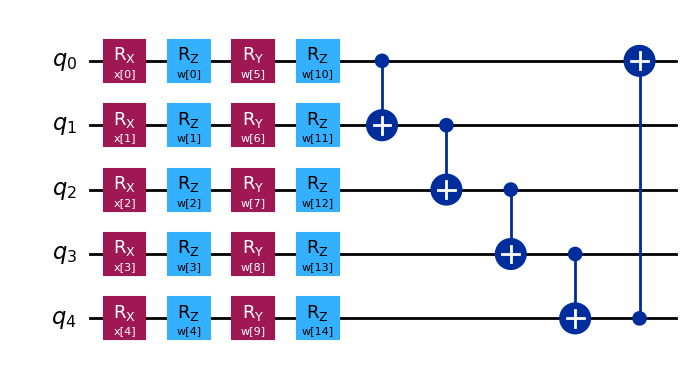

In [5]:
# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc


qnn, qc = create_qnn(5)
qc.draw("mpl")

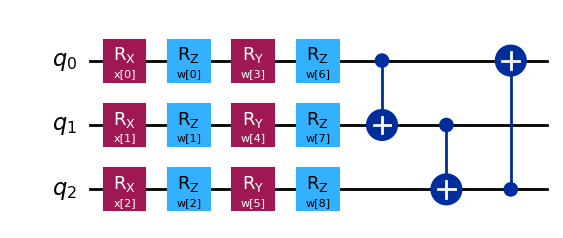

In [11]:
qnn, qc = create_qnn(3)
qc.draw("mpl")

In [7]:
from qiskit_machine_learning.connectors import TorchConnector

from torch.nn import Module, Conv2d, Linear, Flatten, BatchNorm2d
import torch.nn.functional as F

# Define torch NN module
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        # Classical convolutional layer
        self.conv1 = Conv2d(
            in_channels=1, 
            out_channels=16, 
            kernel_size=5,
            padding=2
        )
        self.bn1 = BatchNorm2d(16)
        
        self.conv2 = Conv2d(
            in_channels=16, 
            out_channels=32, 
            kernel_size=5,
            padding=2
        )
        
        # Hybrid dense layers
        self.flatten = Flatten()
        self.fc1 = Linear(in_features=32 * 7 * 7, out_features=5)
        
        # Quantum layer
        self.qnn = TorchConnector(qnn)
        self.fc2 = Linear(1, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.conv2(x)) # Batch normalization ?? ReLU ??
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.fc1(self.flatten(x))) # Batch normalization ??
        
        x = self.qnn(x)
        x = self.fc2(x) # ReLU ?? Batch normalization ??
        return x

model = Net(qnn)

## 3. Training

## 4. Evaluation